In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(".")
# from parc.data import EnergeticMatDataPipeLine as EmData
from parc import misc, metrics, model,visualization
from parc.model import model_burgers
from skimage.measure import block_reduce



2023-11-08 14:10:27.977382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 14:10:28.698036: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data pipeline

In [2]:
import time
import os
import numpy as np
import skimage
from skimage.measure import block_reduce


Re_list = [15,20,30,40,60,80,100,120,140,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]

def clip_raw_data():
    data_whole = []

    for Re in Re_list:
        data_file_name = 'Re_' + str(int(Re)) + '.npy'
#         print(data_file_name)
        file_path = './ns_data/' + data_file_name                
        if os.path.exists(file_path):
            raw_data = np.float32(np.load(file_path))
            raw_data = np.expand_dims(raw_data, axis = 0)
#             raw_data = skimage.measure.block_reduce(raw_data[:,:,:,:], (1,2,2,1),np.max)
            data_shape = raw_data.shape
#             print(data_shape)
#             norm_r = Re/15000
#             r_img = norm_r*np.ones(shape = (data_shape[0],data_shape[1],data_shape[2],1))
#             raw_data = np.concatenate([r_img,raw_data], axis = -1)
#             print(raw_data.shape)
#             print(r_img.shape)
# #                     print(r_img.shape)

#             vel_seq_case = [np.concatenate(
#                 [np.concatenate([np.expand_dims(raw_data[(j + k), :, :, :],axis = 0),r_img],axis = -1)
#                 for k in range(sequence_length)], axis=-1)
#                 for j in range (num_time_steps-sequence_length+1)] 
            data_whole.extend(raw_data)

    data_whole = np.concatenate([data_whole], axis=0)

    return data_whole

seq_clipped = clip_raw_data()



In [3]:
# Normalization
def data_normalization(input_data,no_of_channel):
    norm_data = np.zeros(input_data.shape)
#     norm_data[:,:,:,0:1] = input_data[:,:,:,0:1]
    min_val = []
    max_val = []
    for i in range(no_of_channel):
        norm_data[:,:,:,(i)::no_of_channel] = ((input_data[:,:,:,(i)::no_of_channel] - np.amin(input_data[:,:,:,(i)::no_of_channel])) / (np.amax(input_data[:,:,:,(i)::no_of_channel]) - np.amin(input_data[:,:,:,(i)::no_of_channel])) + 1E-9)
        min_val.append(np.amin(input_data[:,:,:,(i)::no_of_channel]))
        max_val.append(np.amax(input_data[:,:,:,(i)::no_of_channel]))
    return norm_data, min_val, max_val

In [4]:
seq_clipped.shape
seq_norm = data_normalization(seq_clipped, 3)

In [5]:
print(seq_norm[1], seq_norm[2])

[-2.757973, -2.6737006, -255955.38] [4.0362315, 2.584277, 109451.57]


In [6]:
pressure_idx = []
for i in range(117):
    if (i+1)%3 == 0:
        pressure_idx.append(i)
seq_norm_train = np.delete(seq_norm[0], pressure_idx, axis = -1)

In [7]:
seq_norm_train.shape


(36, 128, 256, 78)

In [8]:
Re_list = [15,20,30,40,60,80,100,120,140,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
train_list = [20,30,40,80,100,150,200,250,300,400,450,500,600,650,700,800,850,900,950]
test_list = [15,30,60,140,350,550,750,900,1000]
idx = 0
train_idx =[]
test_idx =[]
for Re in Re_list:
    if Re in train_list:
        train_idx.append(idx)
    elif Re in test_list:
        test_idx.append(idx)
    idx += 1

In [9]:
train_seq = [seq_norm_train[idx:idx+1,:,:,:] for idx in train_idx]
test_seq = [seq_norm_train[idx:idx+1,:,:,:] for idx in test_idx]

In [10]:
train_seq = np.concatenate(train_seq, axis = 0)
test_seq = np.concatenate(test_seq, axis = 0)
print(test_seq.shape)

(7, 128, 256, 78)


In [11]:
print(train_seq.shape)

(19, 128, 256, 78)


In [12]:
def create_train_data(seq, no_of_fields, sequence_length = 2):
    shape = seq.shape
    num_time_steps = np.int32((shape[-1]-1)/3)
    vel_seq_whole = []
#     constant_whole = []
    for i in range(shape[0]):
#         constant = seq[i:i+1,:,:,0:1]
        for j in range(num_time_steps-sequence_length+1):
            vel_seq_case = np.expand_dims(seq[i, :, :, (j*no_of_fields):(j*no_of_fields+sequence_length*no_of_fields)],axis = 0)
#             vel_seq_case = np.concatenate([constant,vel_seq_case],axis = -1)
            vel_seq_whole.extend(vel_seq_case)
    vel_seq_whole = np.concatenate([vel_seq_whole], axis=0)
    return vel_seq_whole

train_data = create_train_data(train_seq, no_of_fields = 2, sequence_length = 11)

In [13]:
print(train_data.shape)

(285, 128, 256, 22)


In [14]:
print(train_data[3,:,:,-2])


[[0.55311447 0.55313158 0.55317652 ... 0.60062999 0.60045803 0.60032016]
 [0.55311447 0.55313158 0.5531764  ... 0.60058379 0.60041249 0.60027647]
 [0.55311447 0.55313152 0.55317628 ... 0.60045642 0.6002841  0.60014594]
 ...
 [0.55311447 0.55313176 0.55317622 ... 0.60048932 0.60031241 0.60017031]
 [0.55311447 0.55313164 0.5531764  ... 0.60061312 0.60043555 0.60029322]
 [0.55311447 0.55313164 0.55317646 ... 0.60065436 0.60047638 0.60033423]]


In [14]:
from tensorflow import keras
from tensorflow.keras import  layers, regularizers
from keras.layers import *
import tensorflow as tf
from parc import layer

from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model

def differentiator_ns():
    # Model initiation
    feature_extraction = layer.feature_extraction_unet(input_shape = (128,256), n_out_features = 64, n_base_features = 64, n_channel = 2)
    
    advection = [layer.Advection() for _ in range(2)]
    diffusion = [layer.Diffusion() for _ in range(2)]
    divergence = layer.Divergence()
    velocity_mapping_and_recon = layer.mapping_and_recon_cnn(input_shape = (128,256), n_base_features = 64, n_mask_channel=4, output_channel=2)

    # Main computation graph
    velocity_field = Input(shape=(128,256, 2), dtype = tf.float32)

    # Reaction term
    dynamic_feature = feature_extraction(velocity_field)

    # u
    advec_u = advection[0](velocity_field[:, :, :, 0:1], velocity_field[:, :, :, :])
    diffusion_u = diffusion[0](velocity_field[:, :, :, 0:1])
    
    # v
    advec_v = advection[1](velocity_field[:, :, :, 1:2], velocity_field[:, :, :, :])
    diffusion_v = diffusion[1](velocity_field[:, :, :, 1:2])    
    
    # div
#     div = divergence([velocity_field[:, :, :, 1:2],velocity_field[:, :, :, 2:3]])
    # Concatenate
    advec_diff_concat = Concatenate(axis=-1)([advec_u,advec_v,diffusion_u,diffusion_v])
    
    # Final mapping
    velocity_dot = velocity_mapping_and_recon([dynamic_feature, advec_diff_concat])
    
    differentiator = Model(velocity_field, velocity_dot)
    return differentiator

def integrator_burgers():
    velocity_integrator = layer.integrator_cnn(input_shape = (128,256), n_base_features = 64, n_output=2)

    velocity_prev = keras.layers.Input(shape = (128,256, 2), dtype = tf.float32)
    velocity_dot = keras.layers.Input(shape = (128,256, 2), dtype = tf.float32)

    velocity_next = velocity_integrator([velocity_dot, velocity_prev])
    integrator = keras.Model([velocity_dot, velocity_prev], [velocity_next])
    return integrator

class PARCv2_ns(keras.Model):
    def __init__(self, n_time_step, step_size, solver = "rk4", mode = "integrator_training", use_data_driven_int = True, differentiator_backbone = 'em', **kwargs):
        super(PARCv2_ns, self).__init__(**kwargs)
        self.n_time_step = n_time_step
        self.step_size = step_size
        self.solver = solver
        self.mode = mode
        self.use_data_driven_int = use_data_driven_int
        self.differentiator = differentiator_ns()
        self.integrator = integrator_burgers()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        if self.mode == "integrator_training":
            self.differentiator.trainable = False
        else:
            self.integrator.trainable = False

    @property
    def metrics(self):
        return [
        self.total_loss_tracker,
        ]
    
    def call(self, input):
        state_var_init = tf.cast(input[0],dtype = tf.float32)
        velocity_init = tf.cast(input[1], dtype = tf.float32)
        input_seq = Concatenate(axis = -1)([state_var_init, velocity_init])

        input_seq_current = input_seq

        res = []
        for _ in range(self.n_time_step):    
            input_seq_current, update = self.explicit_update(input_seq_current)
            if self.use_data_driven_int == True:
                state_var_next, velocity_next = self.integrator([update[:,:,:,:3],update[:,:,:,3:],input_seq_current[:,:,:,:3], input_seq_current[:,:,:,3:]])
                input_seq_current = Concatenate()([state_var_next, velocity_next])
                        
            res.append(input_seq_current)
        return res

    @tf.function
    def train_step(self, data):
        velocity_init = tf.cast(data[0], dtype = tf.float32)
        velocity_gt = tf.cast(data[1], dtype = tf.float32)

        input_seq_current = velocity_init
        with tf.GradientTape() as tape:
            if self.mode == "integrator_training":
                output_snap = []

                for ts in range(self.n_time_step):
                    # Compute k1
                    input_seq_current, update = self.explicit_update(input_seq_current)
                    velocity_next = self.integrator([update, input_seq_current])
                    output_snap.append(velocity_next)
                output = Concatenate(axis = -1)(output_snap)
                
            else:
                output_snap = []
                for ts in range(self.n_time_step):
                    input_seq_current, update = self.explicit_update(input_seq_current)
                    output_snap.append(input_seq_current)
                output = Concatenate(axis = -1)(output_snap)
            total_loss  = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(output,velocity_gt[:,:,:,:])
                           
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
        }
    
    # Update scheme
    def explicit_update(self, input_seq_current):
        input_seq_current = tf.clip_by_value(input_seq_current, 0, 1)

        if self.solver == "rk4":
            input_seq_current, update = self.rk4_update(input_seq_current)
        elif self.solver == 'heun':
            input_seq_current, update = self.heun_update(input_seq_current)
        else:
            input_seq_current, update = self.euler_update(input_seq_current)

        return input_seq_current, update

    def rk4_update(self, input_seq_current):

        # Compute k1
        k1 = self.differentiator(input_seq_current)

        # Compute k2
        inp_k2 = input_seq_current[:,:,:,1:] + self.step_size*1/2*k1
        inp_k2 = Concatenate(axis = -1)([input_seq_current[:,:,:,0:1],inp_k2])

        k2 = self.differentiator(inp_k2)

        # Compute k3
        inp_k3 = input_seq_current[:,:,:,1:] + self.step_size*1/2*k2
        inp_k3 = Concatenate(axis = -1)([input_seq_current[:,:,:,0:1],inp_k3])
        k3 = self.differentiator(inp_k3)

        # Compute k4
        inp_k4 = input_seq_current[:,:,:,1:] + self.step_size*k3
        inp_k4 = Concatenate(axis = -1)([input_seq_current[:,:,:,0:1],inp_k4])

        k4 = self.differentiator(inp_k4)

        # Final
        update = 1/6*(k1 + 2*k2 + 2*k3 + k4)
        final_state = input_seq_current[:,:,:,1:] + self.step_size*update 
        input_seq_current = Concatenate(axis = -1)([input_seq_current[:,:,:,0:1],final_state])
        return input_seq_current, update
    
    # Euler update function
    def heun_update(self, input_seq_current):
        # Compute update
        k1 = self.differentiator(input_seq_current)

        # Compute k2       
        inp_k2 = input_seq_current + self.step_size*k1

        k2 = self.differentiator(inp_k2)
        
        update = 1/2*(k1 + k2)
        final_state = input_seq_current + self.step_size*update 

        return final_state, update
    
#     # Euler update function
#     def euler_update(self, input_seq_current):
#         # Compute update
#         update = self.differentiator(input_seq_current)
#         input_seq_current = input_seq_current + self.step_size*update 

#         return input_seq_current, update

# Training


### Stage 1: Differentiator training

In [15]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices(train_data[:,:,:,:2])
dataset_label = tf.data.Dataset.from_tensor_slices(train_data[:,:,:,2:])
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 798) 
dataset = dataset.batch(4)

2023-11-08 14:10:39.353866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 14:10:41.519041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78887 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [ ]:
# tf.keras.backend.clear_session()
# parc = PARCv2_ns(n_time_step = 10, step_size= 2/38, solver = "heun", mode = "differentiator_training")
# parc.differentiator.load_weights('parc2_diff_ns_heun_no_pressure_600.h5')
# parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005, beta_1 = 0.9, beta_2 = 0.999)
parc.fit(dataset, epochs = 200, shuffle = True)
parc.differentiator.save_weights('parc2_diff_ns_heun_no_pressure_600.h5')

Epoch 1/200
72/72 [==============================] - 42s 580ms/step - total_loss: 146.4522
Epoch 2/200
72/72 [==============================] - 42s 579ms/step - total_loss: 176.8280
Epoch 3/200
72/72 [==============================] - 42s 579ms/step - total_loss: 190.8986
Epoch 4/200
72/72 [==============================] - 42s 580ms/step - total_loss: 151.9505
Epoch 5/200
72/72 [==============================] - 42s 578ms/step - total_loss: 139.0246
Epoch 6/200
72/72 [==============================] - 42s 579ms/step - total_loss: 176.9353
Epoch 7/200
72/72 [==============================] - 42s 579ms/step - total_loss: 184.4522
Epoch 8/200
72/72 [==============================] - 42s 579ms/step - total_loss: 178.7506
Epoch 9/200
72/72 [==============================] - 42s 580ms/step - total_loss: 181.1791
Epoch 10/200
72/72 [==============================] - 42s 580ms/step - total_loss: 258.0361
Epoch 11/200
72/72 [==============================] - 42s 579ms/step - total_loss: 175.56

In [ ]:
# tf.keras.backend.clear_session()
# parc = PARCv2_ns(n_time_step = 7, step_size= 2/38, solver = "heun", mode = "differentiator_training")
# parc.differentiator.load_weights('parc2_diff_ns_heun_no_pressure_300.h5')
# parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999)
parc.fit(dataset, epochs = 100, shuffle = True)
parc.differentiator.save_weights('parc2_diff_ns_heun_no_pressure_400.h5')

In [ ]:
# tf.keras.backend.clear_session()
# parc = PARCv2_ns(n_time_step = 7, step_size= 2/38, solver = "heun", mode = "differentiator_training")
# parc.differentiator.load_weights('parc2_diff_ns_heun_no_pressure_400.h5')
parc.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001, beta_1 = 0.9, beta_2 = 0.999)
parc.fit(dataset, epochs = 100, shuffle = True)
parc.differentiator.save_weights('parc2_diff_ns_heun_no_pressure_400.h5')

In [120]:
parc.differentiator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 128, 256, 1)  0          ['input_6[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 128, 256, 2)  0          ['input_6[0][0]']                
 icingOpLambda)                                                                             

In [41]:
parc.differentiator.save_weights('parc2_diff_ns_heun_no_pressure_600.h5')

### Stage 2: Data-driven integration training

In [27]:
# # Pretrain integrator
# tf.keras.backend.clear_session()
# # Create integrator
# parc = PARCv2_ns(n_time_step = 7, step_size= 2/38, solver = "heun", mode = "integrator_training")
# parc.differentiator.load_weights('parc2_diff_ns_heun_no_pressure_500_2_finetune.h5')
# # parc.integrator.load_weights('parc2_int_ns.h5')
# parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.5, beta_2 = 0.999))
parc.fit(dataset, epochs = 100, shuffle = True)

Epoch 1/100
43/43 [==============================] - 7s 161ms/step - total_loss: 185.8907
Epoch 2/100
43/43 [==============================] - 7s 160ms/step - total_loss: 186.2776
Epoch 3/100
43/43 [==============================] - 7s 161ms/step - total_loss: 183.4651
Epoch 4/100
43/43 [==============================] - 7s 161ms/step - total_loss: 183.6716
Epoch 5/100
43/43 [==============================] - 7s 160ms/step - total_loss: 187.7346
Epoch 6/100
43/43 [==============================] - 7s 160ms/step - total_loss: 179.5036
Epoch 7/100
43/43 [==============================] - 7s 160ms/step - total_loss: 179.5115
Epoch 8/100
43/43 [==============================] - 7s 160ms/step - total_loss: 180.4725
Epoch 9/100
43/43 [==============================] - 7s 160ms/step - total_loss: 179.8944
Epoch 10/100
43/43 [==============================] - 7s 161ms/step - total_loss: 178.8132
Epoch 11/100
43/43 [==============================] - 7s 160ms/step - total_loss: 175.4114
Epoch 12

KeyboardInterrupt: 

In [88]:
parc.integrator.save_weights('parc2_int_ns.h5')

In [10]:
import time
import os
import numpy as np
import skimage
from skimage.measure import block_reduce

# class EnergeticMatDataPipeLine:
#     def __init__(self, **kwargs):
#         super(EnergeticMatDataPipeLine, self).__init__(**kwargs)
    
def clip_raw_data_test(sequence_length=2, n_state_var=3, purpose = "diff_training"):
#     state_seq_whole = []
    vel_seq_whole = []

    for i in range(10):
        for j in range(1,11):
            file_path = os.path.join(os.sep,'Research','parcv2','test_data' f'test_burgers_{i}_{j}.npy')
            if os.path.exists(file_path):
                raw_data = np.float32(np.load(file_path))
                raw_data = np.clip(raw_data,0,1.0)
                raw_data = np.moveaxis(raw_data, 1, -1)

                data_shape = raw_data.shape
                num_time_steps = data_shape[0]
                print(num_time_steps)
                vel_seq_case = [np.concatenate([np.expand_dims(raw_data[(j + k), :, :, :],axis = 0) \
                                        for k in range(sequence_length)], axis=-1) \
                                        for j in range (1)] 


            vel_seq_whole.extend(vel_seq_case)

    vel_seq_whole = np.concatenate(vel_seq_whole, axis=0)
    return vel_seq_whole


In [11]:
# Define sequence length for training
train_seq = clip_raw_data_test(sequence_length = 100)

NameError: name 'Research' is not defined

In [12]:
train_seq.shape

NameError: name 'train_seq' is not defined

In [9]:
vel_seq_norm_whole_test = data_normalization_test(train_seq, vel_seq_norm[1],vel_seq_norm[2], 2)

In [10]:
vel_seq_norm_whole_test.shape

(100, 64, 64, 200)

In [36]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices(vel_seq_norm_whole[:,:,:,:2])
dataset_label = tf.data.Dataset.from_tensor_slices(vel_seq_norm_whole[:,:,:,-2:])
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 10000) 
dataset = dataset.batch(4)

In [40]:
# tf.keras.backend.clear_session()
# parc = model_burgers.PARCv2_burgers(n_time_step = 5, step_size= 1/100, solver = "euler", mode = "integrator_training")
# parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001, beta_1 = 0.5, beta_2 = 0.999))
# parc.differentiator.load_weights('./parc2_diff_burgers_euler.h5')
# parc.integrator.load_weights('./parc2_int_burgers_euler.h5')
parc.fit(dataset, epochs = 25, shuffle = True)

Epoch 1/25
2401/2401 [==============================] - 204s 85ms/step - total_loss: 443.5555
Epoch 2/25
2401/2401 [==============================] - 204s 85ms/step - total_loss: 378.6909
Epoch 3/25
2401/2401 [==============================] - 204s 85ms/step - total_loss: 307.7650
Epoch 4/25
2401/2401 [==============================] - 204s 85ms/step - total_loss: 262.1993
Epoch 5/25
  21/2401 [..............................] - ETA: 3:23 - total_loss: 229.0888

KeyboardInterrupt: 

In [ ]:
parc.integrator.save_weights('parc2_int_euler.h5')

In [70]:
plt.imshow(vel_seq_norm[0][1000,:,:,0])

# Validation

In [ ]:
R_list = [50, 100, 500, 3000, 6500, 12500, 15000]
a_list = [0.35, 0.40, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.00]
w_list = [0.55, 0.6, 0.65, 0.75, 0.85, 0.95, 1.05]

def clip_raw_data_for_validation(idx_range, sequence_length=2, n_state_var=3, purpose = "diff_training"):
    vel_seq_whole = []

    for R in R_list:
        for a in a_list:
            for w in w_list:
                data_file_name = 'burgers_test_' + str(int(R)) + '_' + str(int(a*100)) + '_' + str(int(w*100)) + '.npy'
                print(data_file_name)

                file_path = './test_data/' + data_file_name
                if os.path.exists(file_path):
#                     print(data_file_name)

                    raw_data = np.float32(np.load(file_path))
                    raw_data = np.clip(raw_data,0,1.0)
#                     raw_data = skimage.measure.block_reduce(raw_data[:,:,:,:], (1,,2,1),np.max)
#                     raw_data = np.moveaxis(raw_data, 1, -1)

                    data_shape = raw_data.shape
                    num_time_steps = data_shape[0]
#                     print(num_time_steps)
                    norm_r = R/15000
                    r_img = norm_r*np.ones(shape = (1,data_shape[1],data_shape[2],1))
#                     print(r_img.shape)
#                     print(r_img.shape)
                                      
                    vel_seq_case = [np.concatenate(
                        [np.concatenate([np.expand_dims(raw_data[(j + k), :, :, :],axis = 0),r_img],axis = -1)
                        for k in range(sequence_length)], axis=-1)
                        for j in range (1)] 
                    vel_seq_whole.extend(vel_seq_case)
    print(len(vel_seq_whole))
    vel_seq_whole = np.concatenate(vel_seq_whole, axis=0)

    return vel_seq_whole

seq_clipped_test = clip_raw_data_for_validation((1,100),100)
vel_seq_norm_test = data_normalization_test(seq_clipped_test, vel_seq_norm[1], vel_seq_norm[2], 2)

In [12]:
seq_clipped_test.shape

(441, 128, 128, 300)

In [ ]:
plt.imshow()

In [8]:
idx = 76
input_seq_current = tf.cast(seq_clipped_test[idx:idx+1,:,:,:3], dtype = tf.float32)

res = []
for ts in range(50):
    input_seq_current, update = parc.explicit_update(input_seq_current)
    input_seq_current = tf.clip_by_value(input_seq_current,0,1)
    res.append(input_seq_current)

2023-10-13 11:00:42.749867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-10-13 11:00:47.071159: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [27]:
res[0].shape

TensorShape([1, 128, 128, 3])

In [39]:
print(vel_seq_norm[0][idx:idx+1,:,:,2])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [16]:
out_res = np.concatenate([res])
np.save('parcv2_burgers.npy',out_res)

In [112]:
idx_gt = 295
idx = 95

In [34]:
res[0].shape

TensorShape([1, 128, 128, 3])

In [36]:
len(res)

100

In [ ]:
np.convolve([1,2,3],[0,1,0.5], 'same')
array([1. ,  2.5,  4. ])

In [98]:
# define the high-order finite difference kernels
lapl_op = [[    0,   -1,   0],
             [-1, 4,    -1],
             [    0,   -1,   0]]

partial_y =    [[0, 0, 0],
               [-1/2, 0, 1/2],
               [0, 0, 0]]

partial_x = [[0, 1/2, 0],
               [0, 0, 0],
               [0, -1/2, 0]]

In [13]:
from statistics import mean 
class PdeLossCalculatorBurgers:
    def __init__(self, dt = 1.0, dx = 1.0, **kwargs):
        super(PdeLossCalculatorBurgers, self).__init__(**kwargs)
        self.dt = dt
        self.dx = dx
#     def set_data(self, snapshot_data):
        self.snaphshot_data = snapshot_data
        
    def Laplacian(self, mat, dx = 1.0):
        dY, dX = np.gradient(mat,dx)
        dYY, dYX = np.gradient(dY,dx)
        dXY, dXX = np.gradient(dX,dx)
        laplacian = np.add(dYY,dXX)
        return laplacian
    def TimeDerivative (self,U0, U1, U2):
        return ((U1 - U0) + (U2 - U1))/2/self.dt

    def SnapshotPdeLoss(self, U0, V0, U1, V1, U2, V2, R, dx, dt):
        laplace_u = self.Laplacian(U1, dx)
        laplace_v = self.Laplacian(V1, dx)

        u_x, u_y = np.gradient(U1, dx)
        v_x, v_y = np.gradient(V1, dx)

        u_t_lhs = self.TimeDerivative(U0, U1, U2)
        v_t_lhs = self.TimeDerivative(V0, V1, V2)
        
        # governing equation
        u_t_rhs = (1.0/R) * laplace_u - U1 * u_x - V1 * u_y
        v_t_rhs = (1.0/R) * laplace_v - U1 * v_x - V1 * v_y

        delta_u = np.abs(u_t_lhs - u_t_rhs)
        delta_v = np.abs(v_t_lhs - v_t_rhs)
        combine = np.sqrt(delta_u*delta_u + delta_v*delta_v)
        return np.mean(np.array(delta_u)), np.mean(np.array(delta_v)), np.mean(np.array(combine))
    
    def ComputePdeLoss(self):
        sequence_length = len(self.snaphshot_data)
        pde_loss_seq = []
        f_u_loss = []
        f_v_loss = []
        for i in range(1, sequence_length - 1):
#             print(i)
            snap_shot_pde_loss = self.SnapshotPdeLoss(self.snaphshot_data[i-1][0,:,:,0],self.snaphshot_data[i-1][0,:,:,1], 
                                                          self.snaphshot_data[i][0,:,:,0],self.snaphshot_data[i][0,:,:,1], 
                                                          self.snaphshot_data[i+1][0,:,:,0],self.snaphshot_data[i+1][0,:,:,1], 
                                                          self.snaphshot_data[i][0,0,0,2]*15000, 
                                                          dx = 6/128, dt = 2/100)
            f_u_loss.append(snap_shot_pde_loss[0])
            f_v_loss.append(snap_shot_pde_loss[1])
            pde_loss_seq.append(snap_shot_pde_loss[2])
#         print(pde_loss_array)
        return np.mean(np.array(f_u_loss)), np.mean(np.array(f_v_loss)), np.mean(np.array(pde_loss_seq))
# , pde_loss_array[:,0], pde_loss_array[:,1], np.mean(pde_loss_array[:,2]


# print(loss[1])
# R = np.mean(vel_seq_norm[0][idx,:,:,2])

# # print(R*15000)
# u_t, v_t = rhs(vel_seq_norm[0][idx_gt,:,:,0],vel_seq_norm[0][idx_gt,:,:,1], vel_seq_norm[0][idx_gt+1,:,:,0],vel_seq_norm[0][idx_gt+1,:,:,1], vel_seq_norm[0][idx_gt+2,:,:,0],vel_seq_norm[0][idx+2,:,:,1], vel_seq_norm[0][idx_gt,0,0,2]*15000, dx = 6/128, dt = 2/100)
# print(u_t)

# u_t_res, v_t_res = rhs(res[idx][0,:,:,0],res[idx][0,:,:,1], res[idx+1][0,:,:,0],res[idx+1][0,:,:,1], res[idx+2][0,:,:,0],res[idx+2][0,:,:,1], res[idx][0,0,0,2]*15000, dx = 6/128, dt = 2/100)


In [90]:
test_seq.shape

(15, 64, 128, 78)

In [21]:
# loss_calculator = PdeLossCalculatorBurgers(dt = 2/100, dx = 6/128)
# u_pde_loss = []
# v_pde_loss = []
# combine_pde_loss = []
idx = 10
for j in range(idx,idx+1,1):
    input_seq_current = tf.cast(test_seq[j:j+1,:,:,:2], dtype = tf.float32)
    res = []
    for ts in range(38):
        input_seq_current, update = parc.explicit_update(input_seq_current)
        velocity_next = parc.integrator([update, input_seq_current])
        input_seq_current = tf.clip_by_value(velocity_next,0,1)
        res.append(input_seq_current)
        
#     loss_calculator.set_data(res)
#     pde_loss = loss_calculator.ComputePdeLoss()
#     print('Finish case ', j)
#     u_pde_loss.append(pde_loss[0])
#     v_pde_loss.append(pde_loss[1])
#     combine_pde_loss.append(pde_loss[2])

In [156]:
print(test_seq[idx:idx+1,:,:,0])

[[[0.00933333 0.00933333 0.00933333 ... 0.00933333 0.00933333 0.00933333]
  [0.00933333 0.00933333 0.00933333 ... 0.00933333 0.00933333 0.00933333]
  [0.00933333 0.00933333 0.00933333 ... 0.00933333 0.00933333 0.00933333]
  ...
  [0.00933333 0.00933333 0.00933333 ... 0.00933333 0.00933333 0.00933333]
  [0.00933333 0.00933333 0.00933333 ... 0.00933333 0.00933333 0.00933333]
  [0.00933333 0.00933333 0.00933333 ... 0.00933333 0.00933333 0.00933333]]]


In [72]:
loss_calculator = PdeLossCalculatorBurgers(dt = 2/100, dx = 6/128)
u_pde_loss = []
v_pde_loss = []
combine_pde_loss = []
prediction_data = []
for j in range(441):
    input_seq_current = tf.cast(seq_clipped_test[j:j+1,:,:,:3], dtype = tf.float32)
    res = []
    for ts in range(50):
        input_seq_current, update = parc.explicit_update(input_seq_current)
        input_seq_current = tf.clip_by_value(input_seq_current,0,1)
        res.append(input_seq_current)
    res = np.array(res)
    prediction_data.append(res)
    print('Finish case ', j)


prediction_data = np.array(prediction_data)
        
#     loss_calculator.set_data(res)
#     pde_loss = loss_calculator.ComputePdeLoss()
#     print('Finish case ', j)
#     u_pde_loss.append(pde_loss[0])
#     v_pde_loss.append(pde_loss[1])
#     combine_pde_loss.append(pde_loss[2])

NameError: name 'PdeLossCalculatorBurgers' is not defined

In [16]:
prediction_data = np.squeeze(prediction_data)

In [17]:
prediction_data.shape

(441, 50, 128, 128, 3)

In [18]:
np.save('prediction_data.npy',prediction_data)

In [19]:
mean(combine_pde_loss)
# np.mean(combine_pde_loss_array)

0.0005418794

In [51]:
plt.imshow(combine_pde_loss[96,:,:], vmin = 0, vmax = 1)
# np.amax(combine_pde_loss[0][96,:,:])

TypeError: list indices must be integers or slices, not tuple

In [15]:
combine_pde_loss_array.shape

(41, 98, 128, 128)

In [16]:
np.mean(combine_pde_loss_array[20:40,:,:,:])

0.11262727

In [75]:
mean_pde_loss = np.mean(np.abs(u_t_res))
# print(mean_pde_loss)

0.0020067291


In [73]:
u_pde_loss = []
v_pde_loss = []
for i in range(160):
    u_pde_loss.append(pde_loss[i][1])
    v_pde_loss.append(pde_loss[i][2])

In [28]:
x = np.linspace(1,46,46)
print(x)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.]


In [20]:
# u_pde_loss = np.array(u_pde_loss)
# v_pde_loss = np.array(v_pde_loss)
# combine_pde_loss = np.array(combine_pde_loss)

u_loss_w_r = []
u_loss_w_r.append(np.mean(u_pde_loss[:20]))
u_loss_w_r.append(np.mean(u_pde_loss[20:40]))
u_loss_w_r.append(np.mean(u_pde_loss[40:60]))
u_loss_w_r.append(np.mean(u_pde_loss[60:]))
print(u_loss_w_r)
    
v_loss_w_r = []
v_loss_w_r.append(np.mean(v_pde_loss[:20]))
v_loss_w_r.append(np.mean(v_pde_loss[20:40]))
v_loss_w_r.append(np.mean(v_pde_loss[40:60]))
v_loss_w_r.append(np.mean(v_pde_loss[60:]))
print(v_loss_w_r)

combine_loss_w_r = []
combine_loss_w_r.append(np.mean(combine_pde_loss[:20]))
combine_loss_w_r.append(np.mean(combine_pde_loss[20:40]))
combine_loss_w_r.append(np.mean(combine_pde_loss[40:60]))
combine_loss_w_r.append(np.mean(combine_pde_loss[60:]))
print(combine_loss_w_r)
R_list = [500, 3000, 6500, 1500]


[0.0003928106, 0.00034514075, 0.0003592898, 0.00040270746]
[0.00041563465, 0.00034444683, 0.00035274934, 0.00039529806]
[0.0005808347, 0.0004980989, 0.0005142415, 0.0005743423]


In [48]:
# plt.imshow(u_pde_loss[0][97])
combine_pde_loss[0] = np.array(combine_pde_loss[0])

np.mean(combine_pde_loss[0])
# np.amax(combine_pde_loss[0][97])

0.25949794

In [38]:
np.mean((u_pde_loss[0][:][1]))

0.00025922665

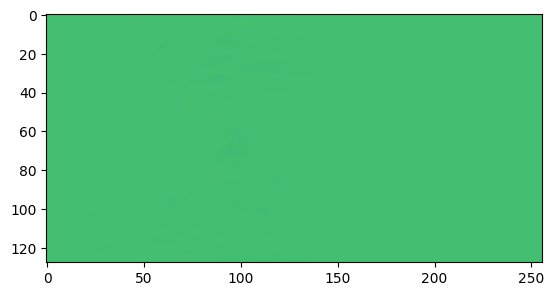

In [29]:
plt.imshow(res[1][0,:,:,3],vmin = 0, vmax = 1)


In [25]:
print(combine_pde_loss)

[0.0022563946, 0.0009519622, 0.0002969871, 3.833456e-05, 0.023159433, 0.017478965, 0.0131124975, 0.009133591, 0.08101326, 0.06664302, 0.05395363, 0.04501426, 0.17672913, 0.15184055, 0.13702792, 0.118816674, 0.26375815, 0.24313812, 0.22596751, 0.20035441, 0.0066559566]


In [29]:
plt.plot(x,combine_pde_loss)

In [ ]:
plt.imshow(np.abs(v_t), vmin = 0, vmax = 1)
plt.show()
plt.imshow(np.abs(v_t_res), vmin = 0, vmax = 1)
plt.show()

In [ ]:
test_list = [15,20,120,140,350,550,750,950]


In [22]:
idx = 2

In [28]:
test_seq.shape

(7, 128, 256, 78)

In [20]:
idx = 0
for j in range(idx,idx+1,1):
    input_seq_current = tf.cast(test_seq[j:j+1,:,:,:2], dtype = tf.float32)
    res = []
    for ts in range(38):
        input_seq_current, update = parc.explicit_update(input_seq_current)
#         velocity_next = parc.integrator([update, input_seq_current])
        input_seq_current = tf.clip_by_value(input_seq_current,0,1)
        res.append(input_seq_current)

/tmp/ipykernel_967371/318471279.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1,4, figsize = (15,55))


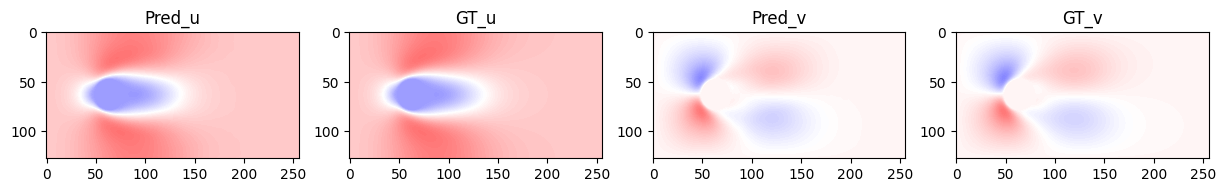

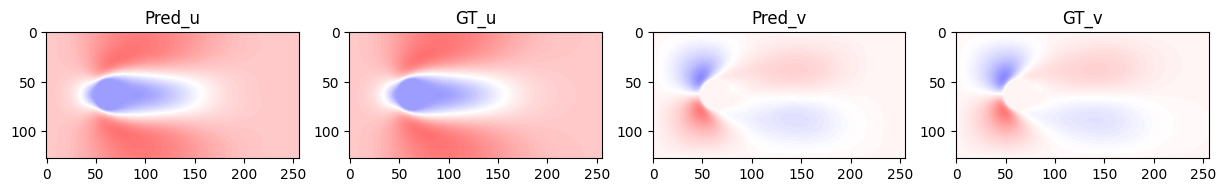

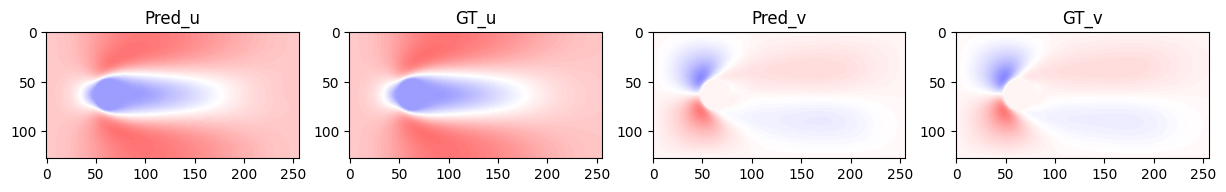

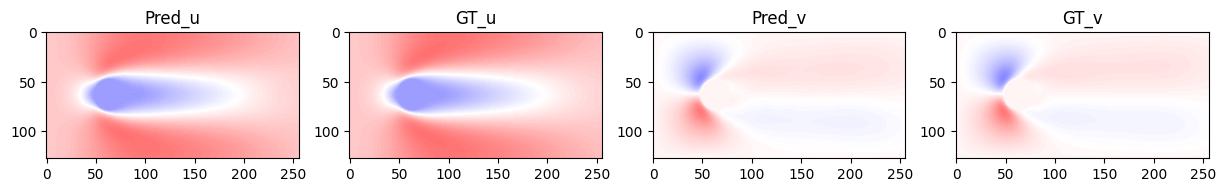

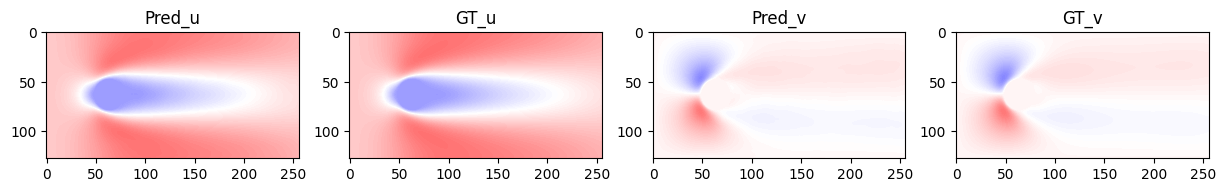

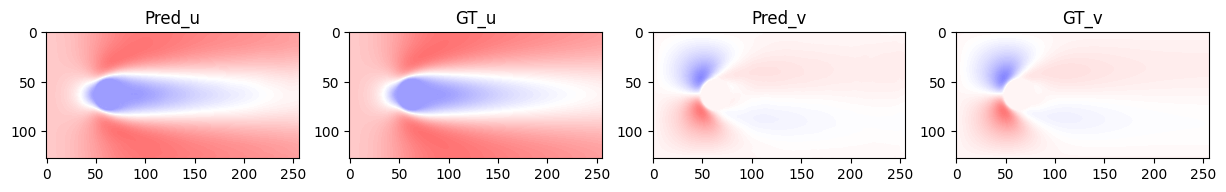

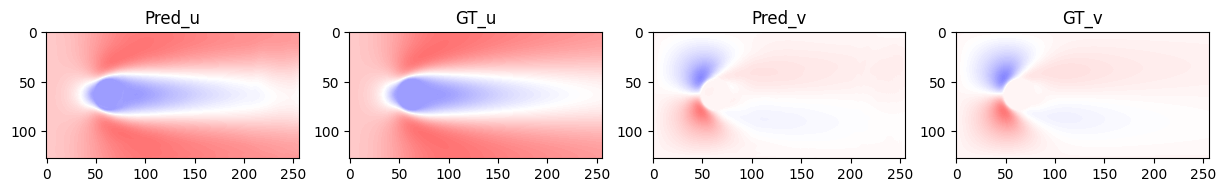

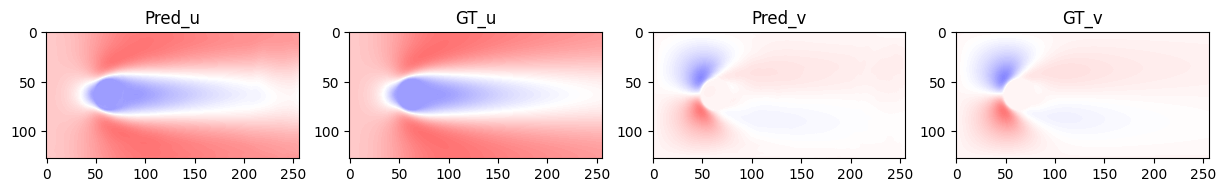

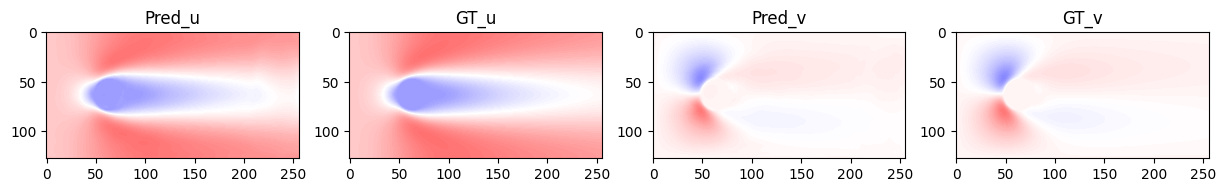

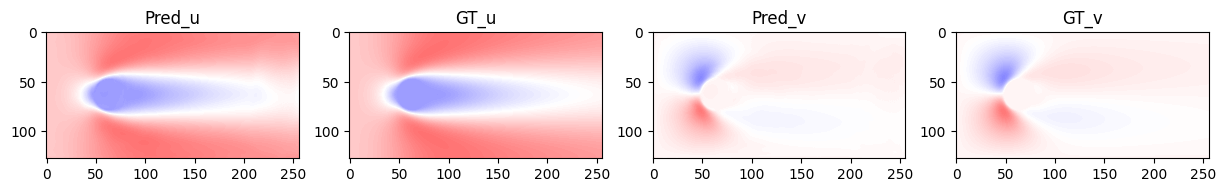

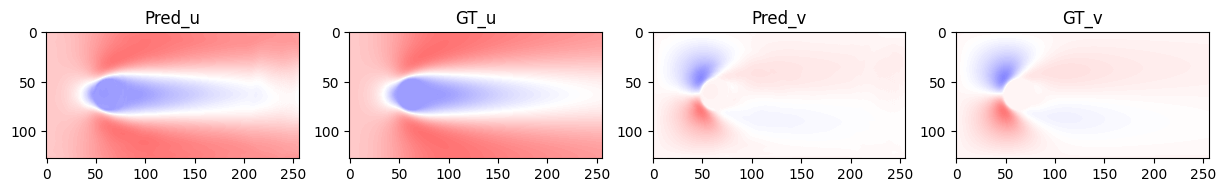

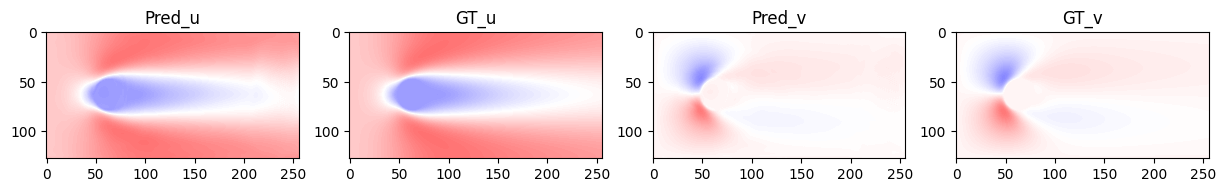

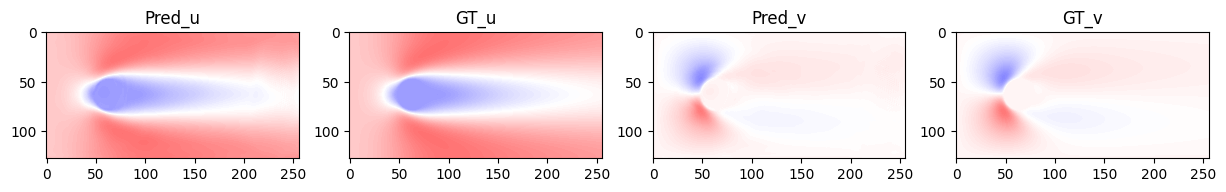

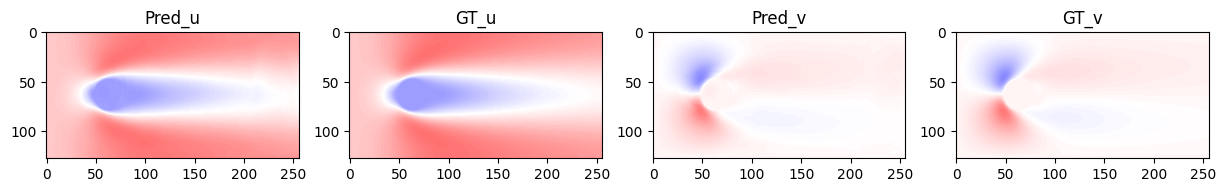

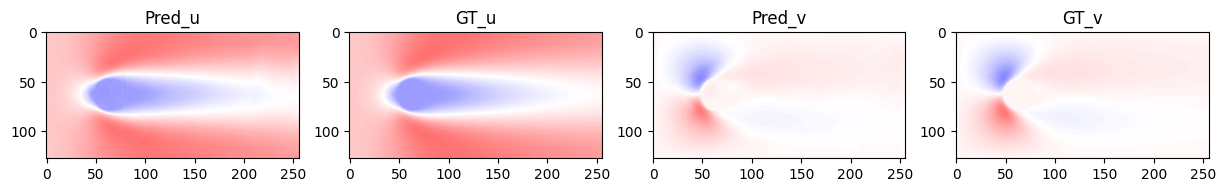

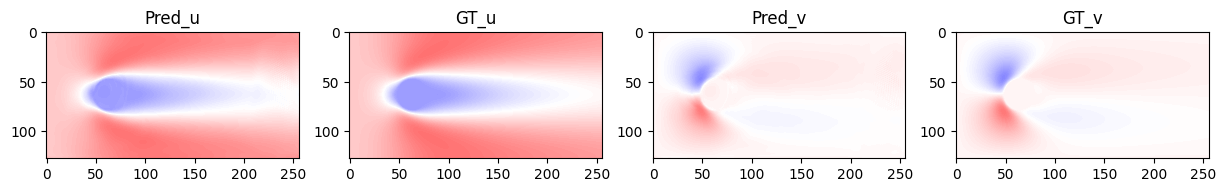

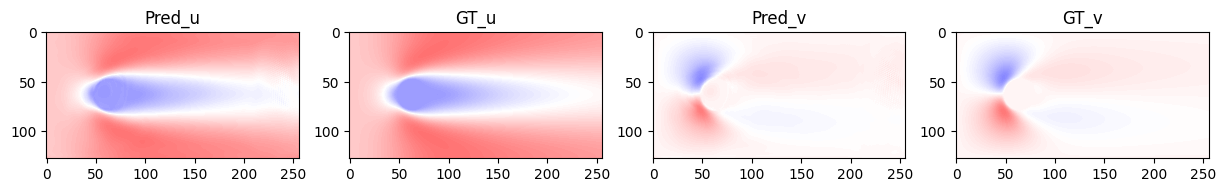

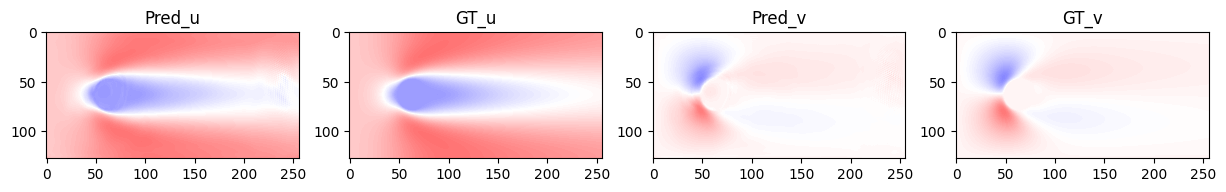

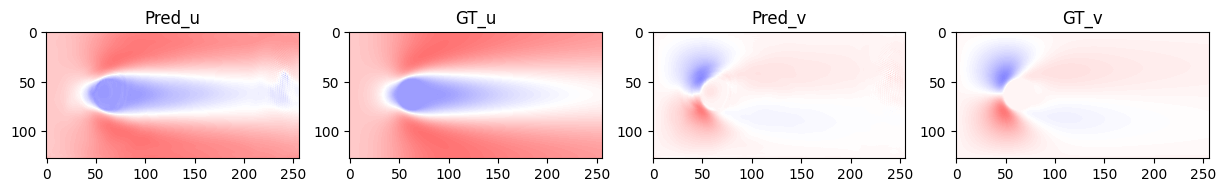

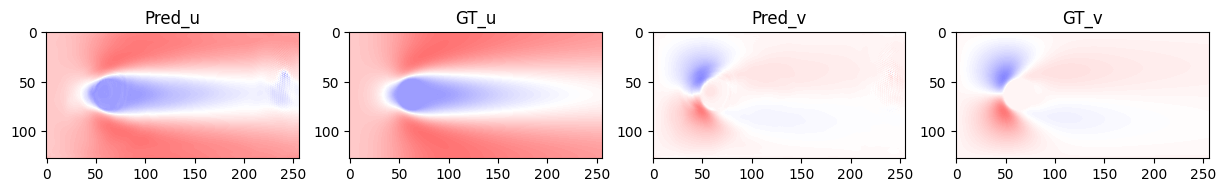

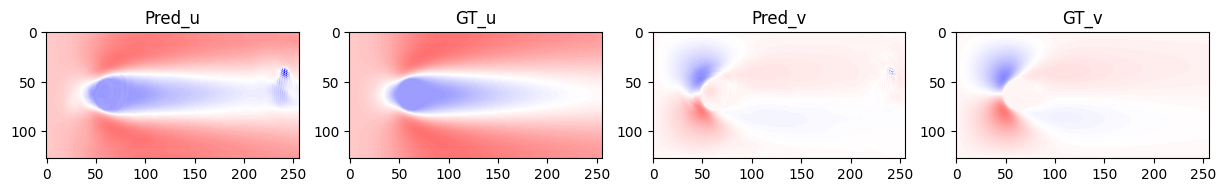

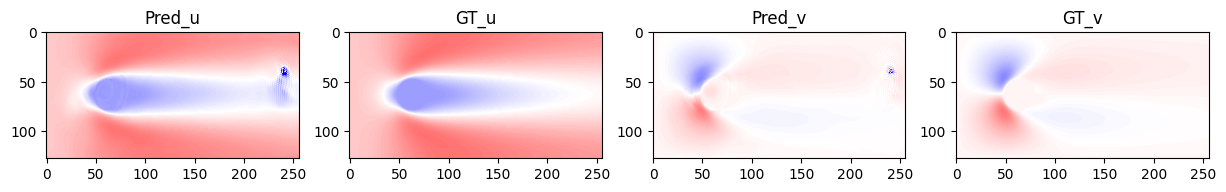

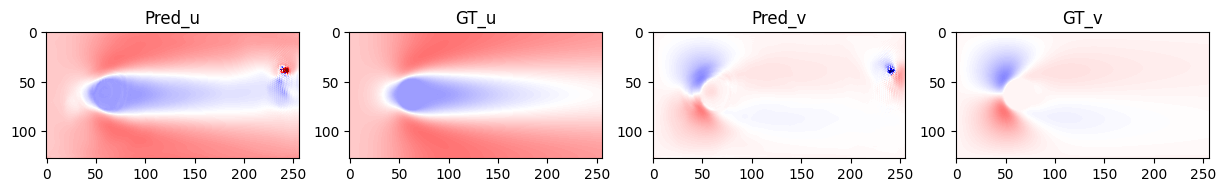

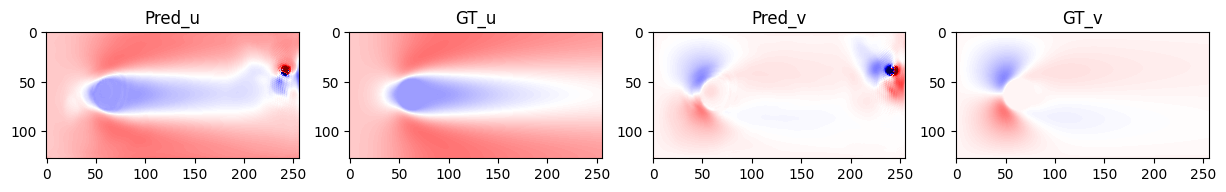

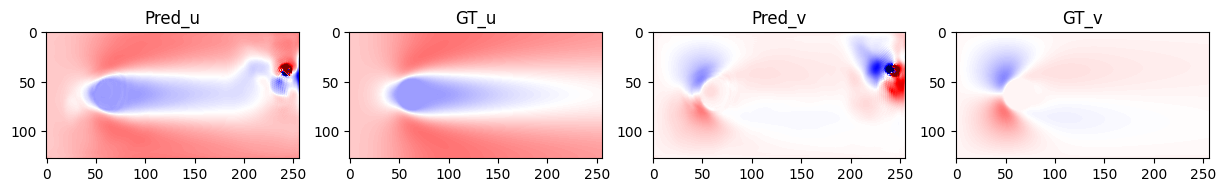

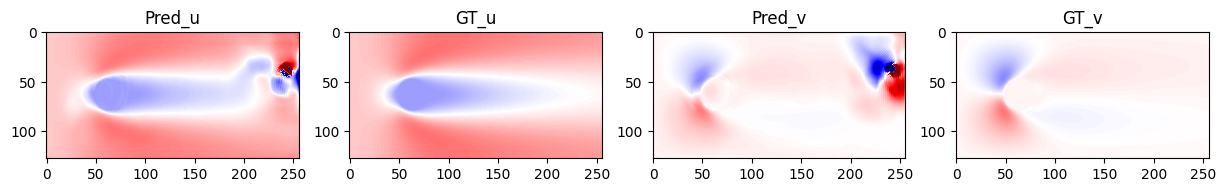

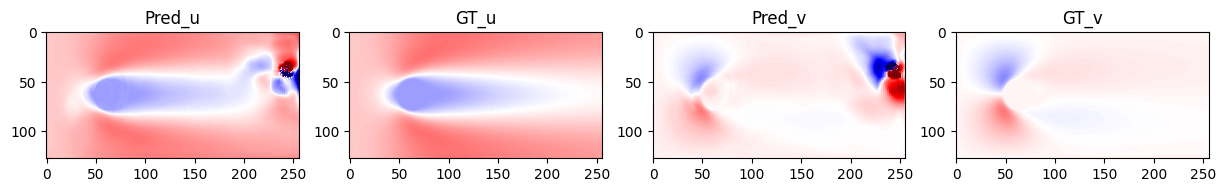

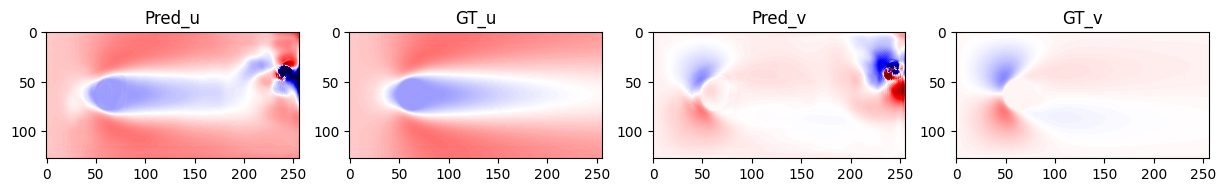

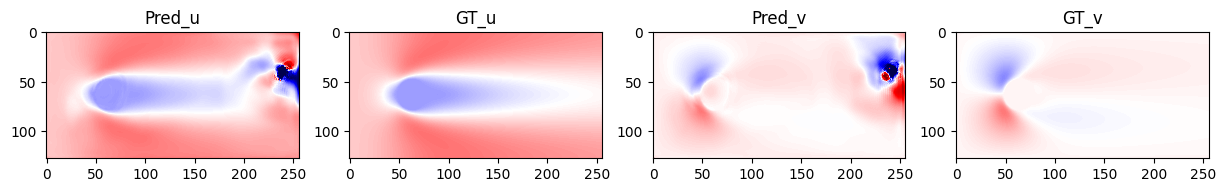

In [21]:
for i in range(38):
#     if i % 4 == 0:
    _, ax = plt.subplots(1,4, figsize = (15,55))
    ax[0].imshow(res[i][0,:,:,0], cmap = 'seismic', vmin = 0, vmax = 1)
    ax[0].title.set_text('Pred_u')

    ax[1].imshow(test_seq[idx,:,:,(i+1)*2], cmap = 'seismic',vmin = 0, vmax = 1)
    ax[1].title.set_text('GT_u')

    ax[2].imshow(res[i][0,:,:,1], cmap = 'seismic', vmin = 0, vmax = 1)
    ax[2].title.set_text('Pred_v')

    ax[3].imshow(test_seq[idx,:,:,(i+1)*2+1], cmap = 'seismic', vmin = 0, vmax = 1)
    ax[3].title.set_text('GT_v')

#     ax[4].imshow(res[i][0,:,:,3], vmin = 0.5, vmax = 1)
#     ax[4].title.set_text('Pred_p')

#     ax[5].imshow(test_seq[idx,:,:,(i+1)*3+3], vmin = 0.5, vmax = 1)
#     ax[5].title.set_text('GT_p')

In [37]:
vel_seq_norm_test.shape

(40, 128, 128, 300)

In [45]:
print(vel_seq_norm[0][0,:,:,2])
plt.colorbar()


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 640x480 with 0 Axes>

In [34]:
R = np.mean(vel_seq_norm[0][idx,:,:,2])

In [ ]:
for i in range(8000, 8100, 1):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(np.squeeze(vel_seq_norm[0][i,:,:,0]),vmin = 0, vmax =0.9)
    ax[1].imshow(np.squeeze(res[i-idx][:,:,:,0]),vmin = 0, vmax =0.9)
#     ax[2].imshow(np.squeeze(np.abs(res[i][:,:,:,0]-vel_seq_norm_whole_test[idx,:,:,i*2])),vmin = 0, vmax =1)
    plt.show()

In [3]:
# Measure PDE loss


## Load model

In [74]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 15, step_size= 1/15, solver = "rk4", mode= "integrator_training")
parc_rk.compile()
parc_rk.differentiator.load_weights('./pretrained_weights/parc2_diff_rk4.h5')
parc_rk.integrator.load_weights('./pretrained_weights/parc2_int_rk4.h5')

In [69]:
tf.keras.backend.clear_session()
parc_euler = model.PARCv2(n_state_var = 3, n_time_step = 15, step_size= 1/15, solver = "euler", mode= "integrator_training")
parc_euler.compile()
parc_euler.differentiator.load_weights('./pretrained_weights/parc2_diff_euler.h5')
parc_euler.integrator.load_weights('./pretrained_weights/parc2_int_euler.h5')

## Field evolution plot

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from scipy.ndimage import gaussian_filter
from PIL import ImageFilter, Image
from IPython.display import display

def plot_field_evolution_comparison(y_pred_rk, y_pred_euler, y_true, state_var_type="temperature"):
    """Visualize the prediction
    :param y_pred:          (numpy) predicted fields
                            [0, ...] predicted fields (F)
                            [1, ...] predicted change of fields (F_dot)
    :param y_true:          (numpy) true label of the fields
    :param test_sample_no:  (int)   array index to select the test case
    :state_var_type:        (str)   indicate which fields to plot the result to apply correct scaling
    """

    # get correct scaling terms
    if state_var_type == "temperature":
        opts = 0
        opts_2 = 0
        step = 6
        min_val = 300  # min temperature (K)
        max_val = 5000  # max temperature (K)
        unit = "(K)"
        title = "Temperature field evolution ($P_s$ = 9.5 GPa) "
    elif state_var_type == "pressure":
        opts = 1
        opts_2 = 1
        step = 6
        min_val = -2  # min pressure (GPa)
        max_val = 50  # max pressure (GPa)
        unit = "(GPa)"
        title = "Pressure field evolution ($P_s$ = 9.5 GPa) "

    elif state_var_type == "vel_x":
        opts = 0
        opts_2 = 3
        step = 4
        min_val = -1739.868  # min vel (m/s)
        max_val = 9278.142  # max vel (m/s)
        unit = "(m/s)"
        title = "Horizontal velocity field evolution ($P_s$ = 9.5 GPa) "

    elif state_var_type == "vel_y":
        opts = 1
        opts_2 = 4
        step = 4
        min_val = -4335.711  # min vel (m/s)
        max_val = 5491.27  # max vel (m/s)
        unit = "(m/s)"
        title = "Vertical velocity field evolution ($P_s$ = 9.5 GPa) "

    else:
        print(
            state_var_type,
            " is not supported. Choose either 'temperature' or 'pressure'.",
        )
        return None

    # plot the prediction results
    x_num = np.linspace(1, 15, 15)  # discrete timesteps
    fig, ax = plt.subplots(3, 8, figsize=(46, 13.5))
    plt.subplots_adjust(wspace=0.06, hspace=0.07, top=0.85)
    fig.suptitle(title, fontsize=36)
    for i in range(8):
        ax[0][i].clear()
        ax[0][i].clear()
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        im = ax[0][i].imshow(
            np.squeeze(y_true[0, :, :, (i) * step + opts]),
            cmap="jet",
            vmin=0,
            vmax=1,
        )
        ax[0][i].set_title(("t = " + "%.2f" % x_num[i * 2]), fontsize=32)

        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        ax[1][i].imshow(
            np.squeeze(y_pred_rk[i*2][0, :, :, opts_2]),
            cmap="jet",
            vmin=0,
            vmax=1)
            
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        ax[2][i].imshow(
            np.squeeze(y_pred_euler[i*2][0, :, :, opts_2]),
            cmap="jet",
            vmin=0,
            vmax=1)
        
    ax[0][0].set_ylabel("GT", fontsize=32)
    ax[1][0].set_ylabel("PARC-RK4", fontsize=32)
    ax[2][0].set_ylabel("PARC-Euler", fontsize=32)
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.125, 0.015, 0.715])
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap="jet"), cax=cbar_ax, ax=im
    )
    cbar.set_label(label=unit, weight="bold", fontsize=36)
    cbar.ax.tick_params(labelsize=36)
    plt.show()

In [106]:
parc.use_data_driven_int = True
parc.compile()
# parc.n_time_step = 15


In [94]:
# Make prediction
case_idx = 28
state_var_current = state_seq_norm_test[case_idx:case_idx+1,:,:,0:3]
velocity_current = vel_seq_norm_test[case_idx:case_idx+1,:,:,0:2]
pred_state_rk = parc_rk.predict([state_var_current,velocity_current])
pred_state_euler = parc_euler.predict([state_var_current,velocity_current])


1/1 [==============================] - 0s 283ms/step


In [116]:
fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(np.squeeze(state_seq_norm_test[case_idx, :, :, 2]), cmap="gray", vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Temperature

In [113]:
plot_field_evolution_comparison(pred_state_rk, pred_state_euler, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="temperature")

In [115]:
plot_field_evolution_comparison(pred_state_rk, pred_state_euler, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="pressure")

### Pressure

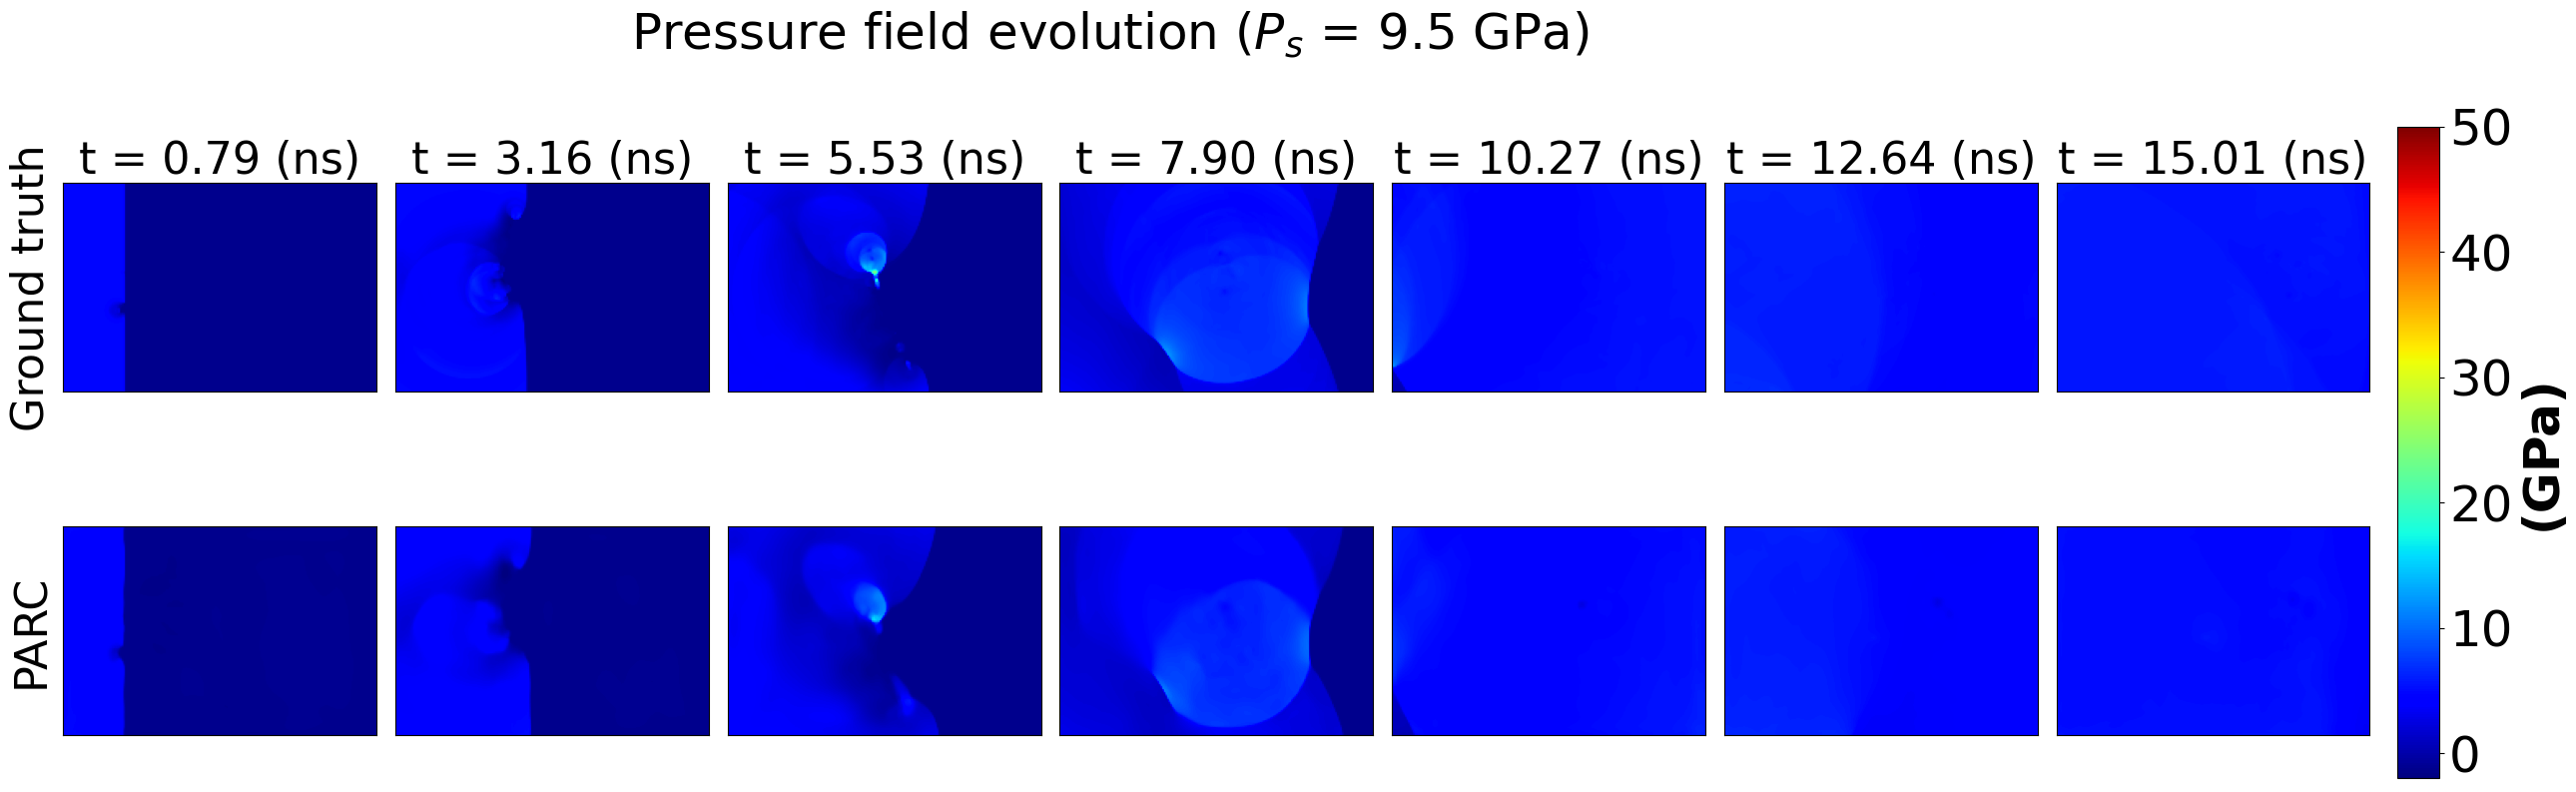

In [65]:
visualization.plot_field_evolution(pred_state, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="pressure")

### Velocity in x direction

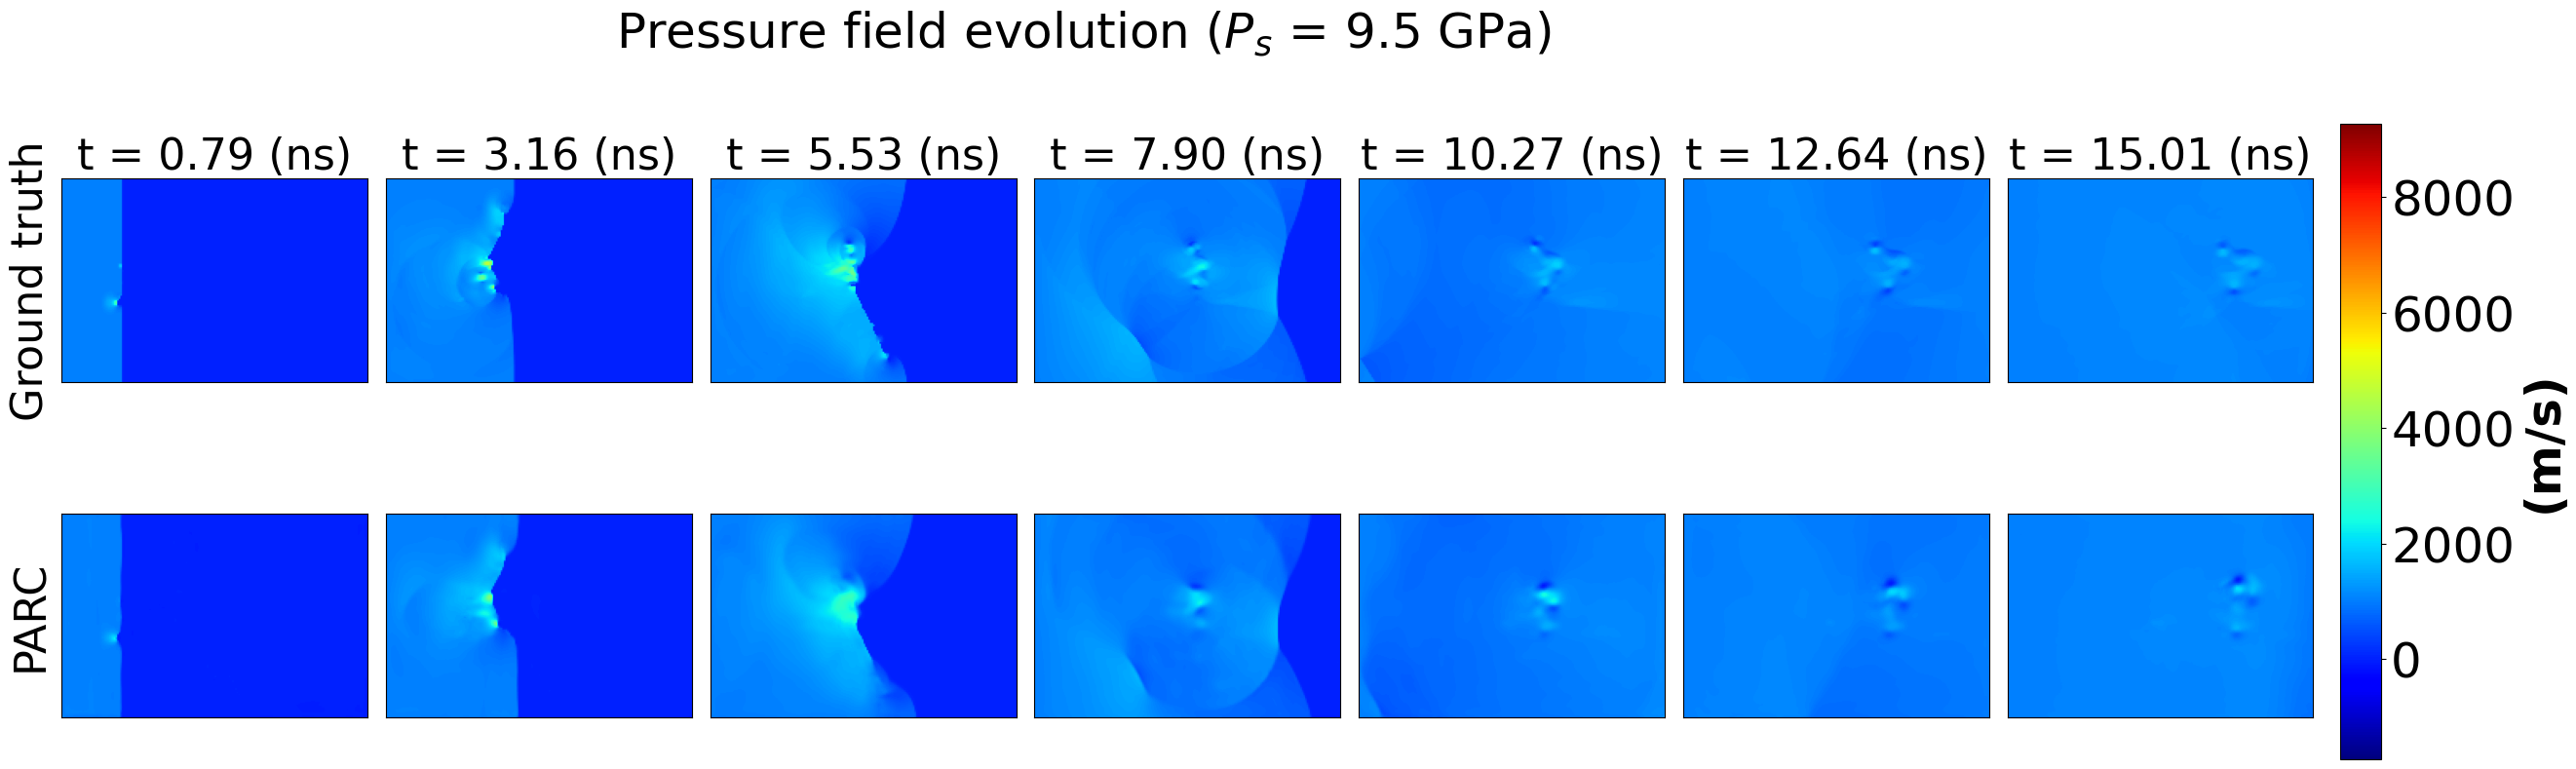

In [67]:
visualization.plot_field_evolution(pred_state, vel_seq_norm_test[case_idx:case_idx+1,:,:,2:], state_var_type="vel_x")

### Velocity in y direction

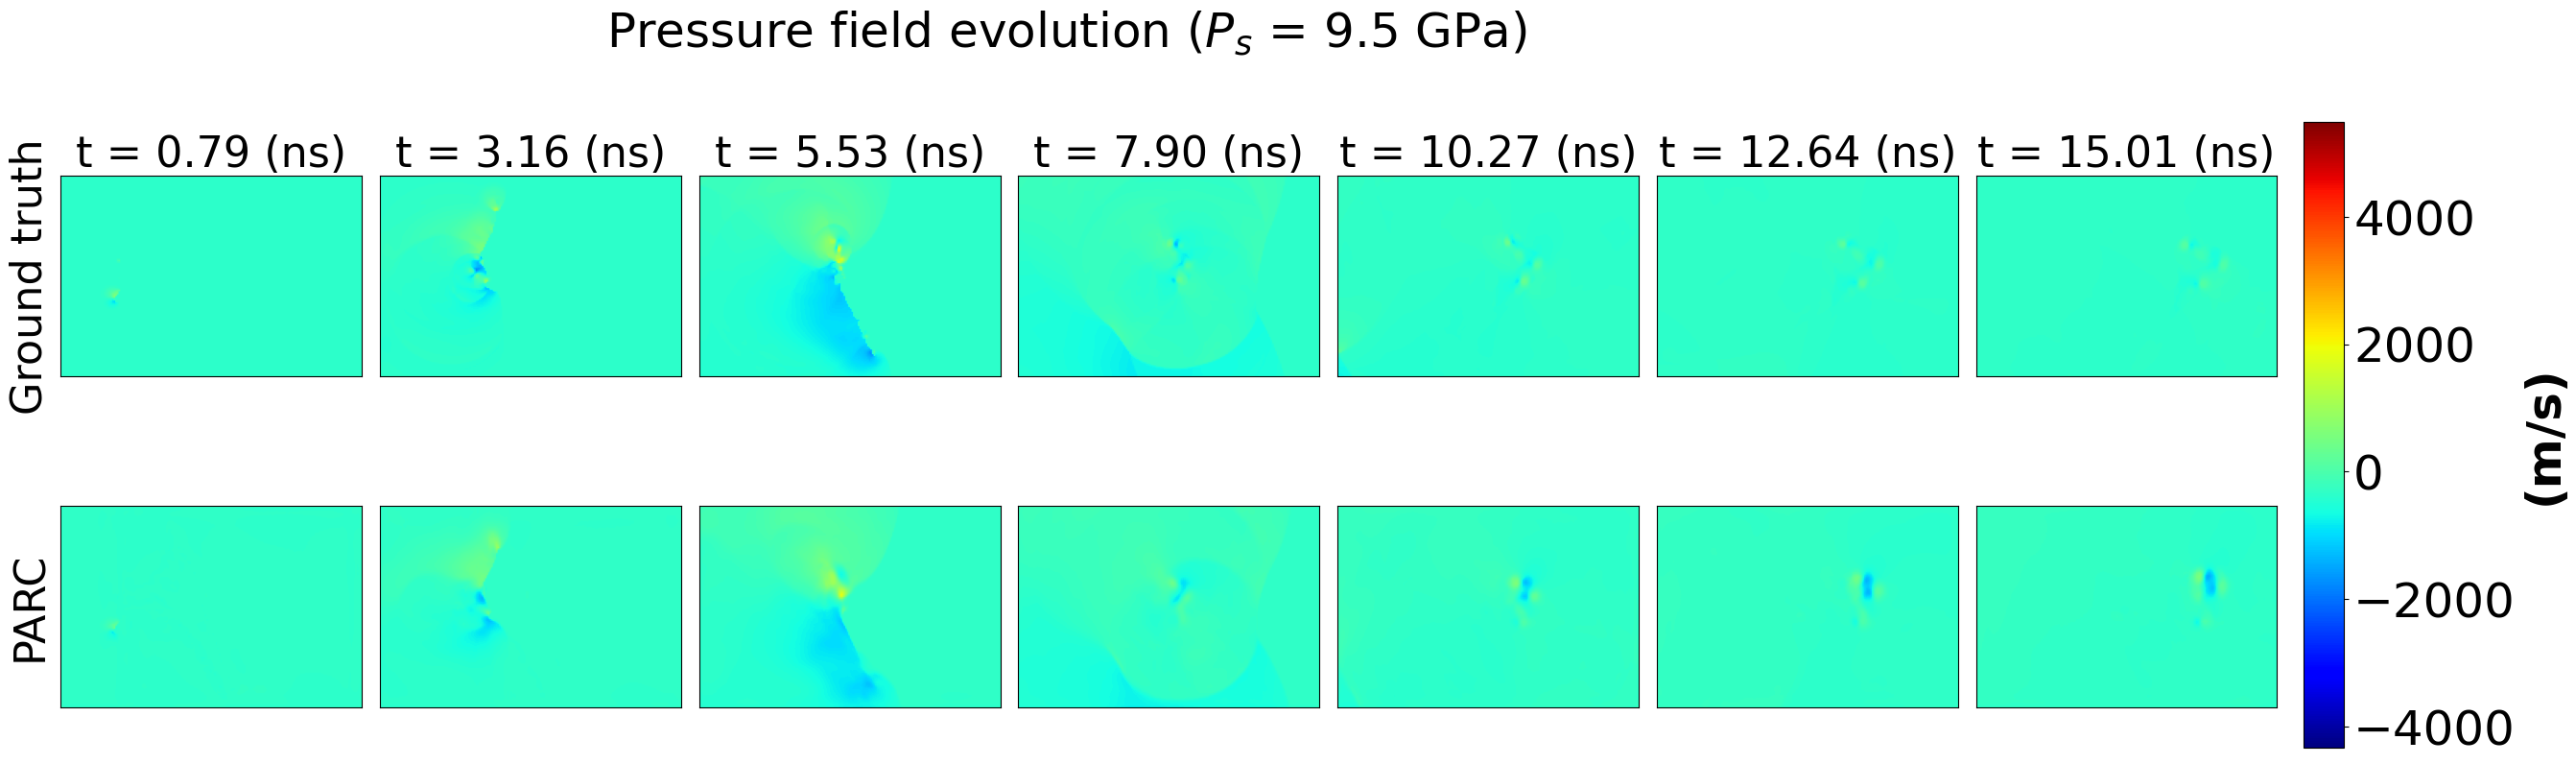

In [68]:
visualization.plot_field_evolution(pred_state, vel_seq_norm_test[case_idx:case_idx+1,:,:,2:], state_var_type="vel_y")

### Quantitative analysis

In [122]:
state_rk = []
outlier = [0,3,30,32,33, 8, 10, 19, 24]
# outlier = []
for idx in range(34):
    if idx not in outlier:
        print(idx)
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx+1,:,:,0:2]
        pred_state = parc_rk.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_rk.append(pred_state_case)
state_rk = np.concatenate(state_rk, axis = 0)
print(state_rk.shape)       

1
1/1 [==============================] - 1s 768ms/step
(1, 128, 192, 75)
2
1/1 [==============================] - 1s 731ms/step
(1, 128, 192, 75)
4
1/1 [==============================] - 1s 731ms/step
(1, 128, 192, 75)
5
1/1 [==============================] - 1s 730ms/step
(1, 128, 192, 75)
6
1/1 [==============================] - 1s 725ms/step
(1, 128, 192, 75)
7
1/1 [==============================] - 1s 722ms/step
(1, 128, 192, 75)
9
1/1 [==============================] - 1s 728ms/step
(1, 128, 192, 75)
11
1/1 [==============================] - 1s 730ms/step
(1, 128, 192, 75)
12
1/1 [==============================] - 1s 731ms/step
(1, 128, 192, 75)
13
1/1 [==============================] - 1s 727ms/step
(1, 128, 192, 75)
14
1/1 [==============================] - 1s 727ms/step
(1, 128, 192, 75)
15
1/1 [==============================] - 1s 730ms/step
(1, 128, 192, 75)
16
1/1 [==============================] - 1s 730ms/step
(1, 128, 192, 75)
17
1/1 [==============================] - 1s 

In [123]:
state_euler = []
outlier = [0,3,30,32,33, 8, 10, 19, 24]
# outlier = []
for idx in range(34):
    if idx not in outlier:
        print(idx)
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx+1,:,:,0:2]
        pred_state = parc_euler.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_euler.append(pred_state_case)
state_euler = np.concatenate(state_euler, axis = 0)
print(state_euler.shape)       

1
1/1 [==============================] - 0s 284ms/step
(1, 128, 192, 75)
2
1/1 [==============================] - 0s 279ms/step
(1, 128, 192, 75)
4
1/1 [==============================] - 0s 277ms/step
(1, 128, 192, 75)
5
1/1 [==============================] - 0s 279ms/step
(1, 128, 192, 75)
6
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
7
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
9
1/1 [==============================] - 0s 278ms/step
(1, 128, 192, 75)
11
1/1 [==============================] - 0s 278ms/step
(1, 128, 192, 75)
12
1/1 [==============================] - 0s 278ms/step
(1, 128, 192, 75)
13
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
14
1/1 [==============================] - 0s 279ms/step
(1, 128, 192, 75)
15
1/1 [==============================] - 0s 279ms/step
(1, 128, 192, 75)
16
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
17
1/1 [==============================] - 0s 

In [124]:
## Preprocess temperature data
# Get temperature field evolution
Temp_gt = state_seq_norm_test[:,:,:,3::3]    # Ground truth temperature field evolution
# Temp_gt = np.clip(Temp_gt,0,1)
Temp_pred_parc_rk = state_rk[:,:,:,0::5]   # PARC prediction temperature field evolution
Temp_pred_parc_euler = state_euler[:,:,:,0::5]   # PARC prediction temperature field evolution

# # Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_euler = misc.scale_temperature(temperatures = Temp_pred_parc_euler, start_ts = 0, max_temp = 5000, min_temp = 300)

# Compute sensitivity of ground truth data
gt_hs_temp, gt_hs_area = metrics.calculate_hotspot_metric(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)
gt_rate_hs_temp,gt_rate_hs_area = metrics.calculate_hotspot_metric_rate_of_change(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_rk, parc_hs_area_rk = metrics.calculate_hotspot_metric(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_rk, parc_rate_hs_area_rk = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_euler, parc_hs_area_euler = metrics.calculate_hotspot_metric(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_euler, parc_rate_hs_area_euler = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

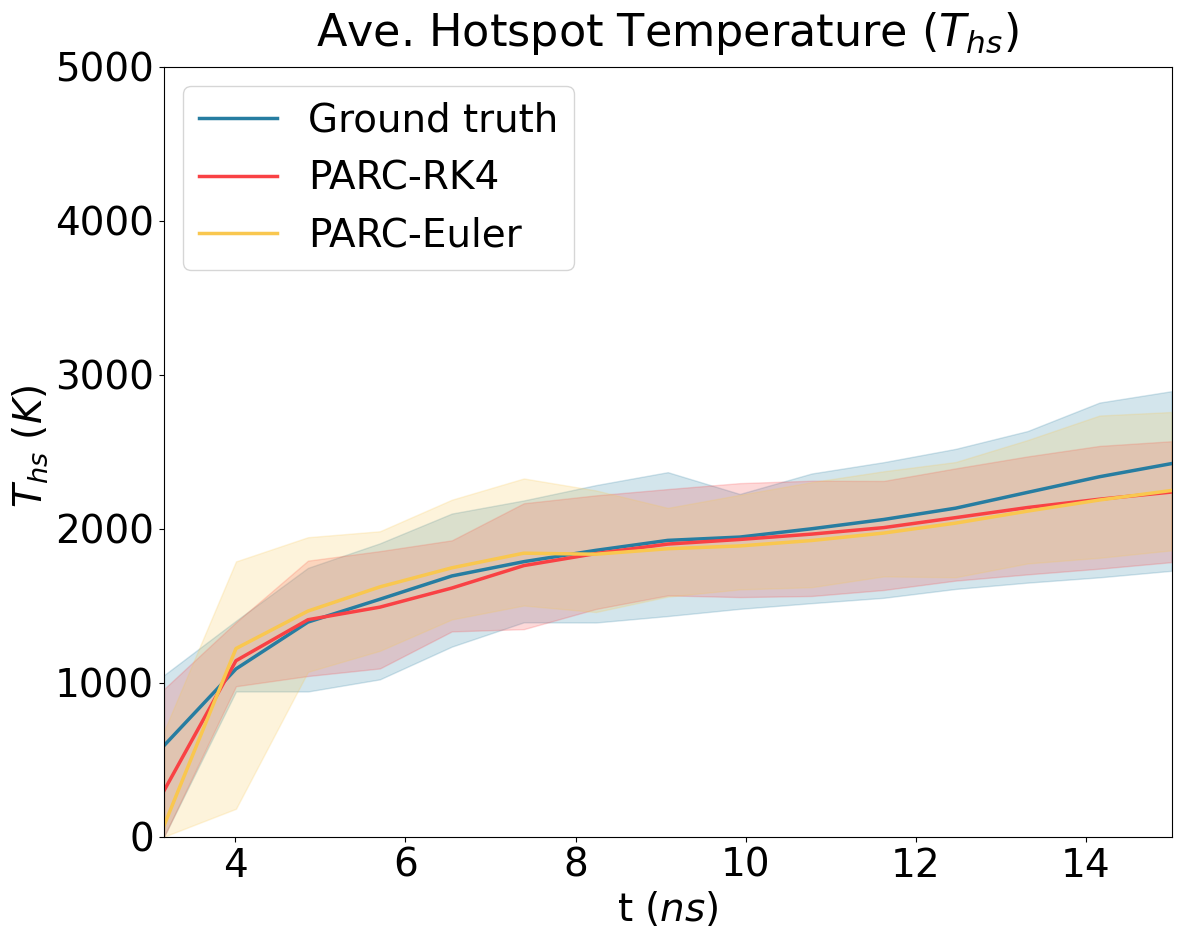

In [158]:
plot_sensitivity(y_true=gt_hs_temp, y_pred_rk=parc_hs_temp_rk, y_pred_euler = parc_hs_temp_euler,  metric='hs_temp',ts=15)

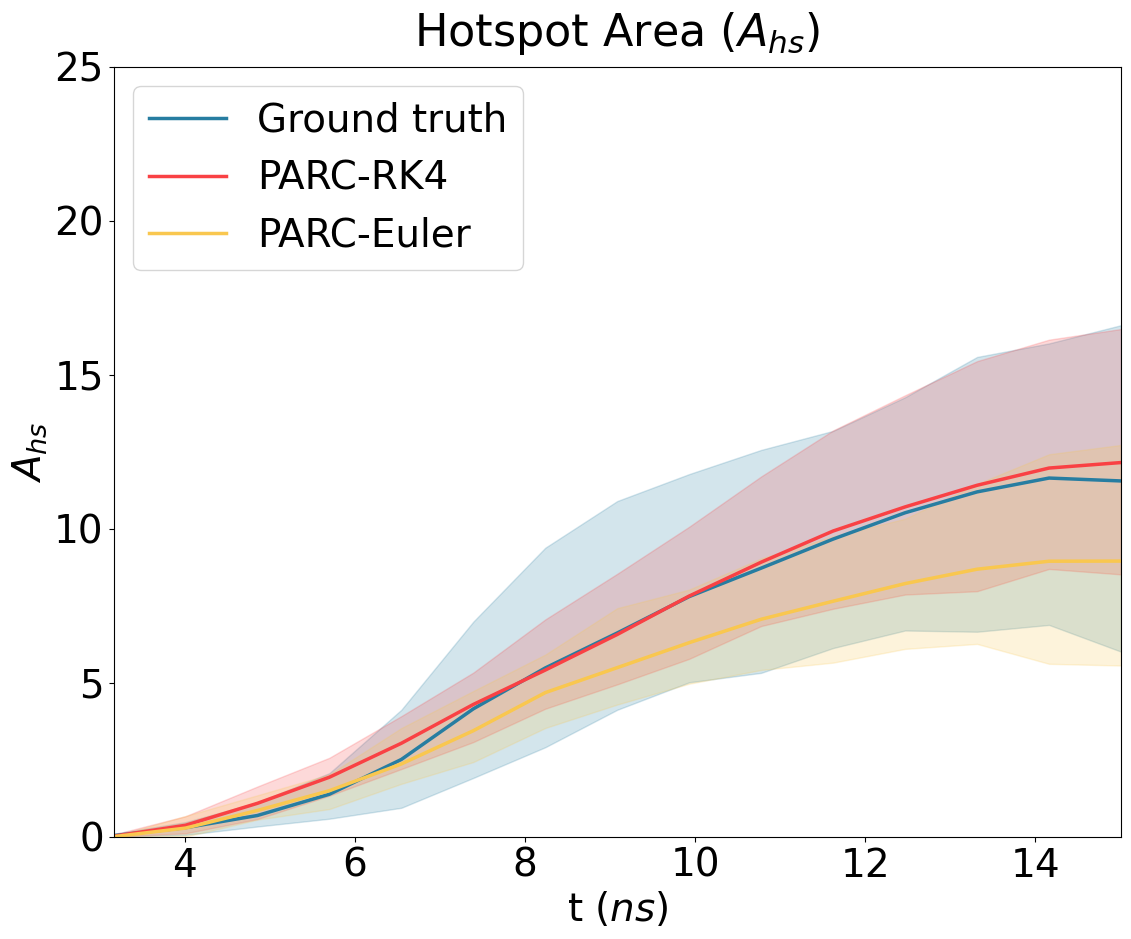

In [154]:
plot_sensitivity(y_true=gt_hs_area, y_pred_rk=parc_hs_area_rk, y_pred_euler = parc_hs_area_euler, metric='hs_area',ts=15)

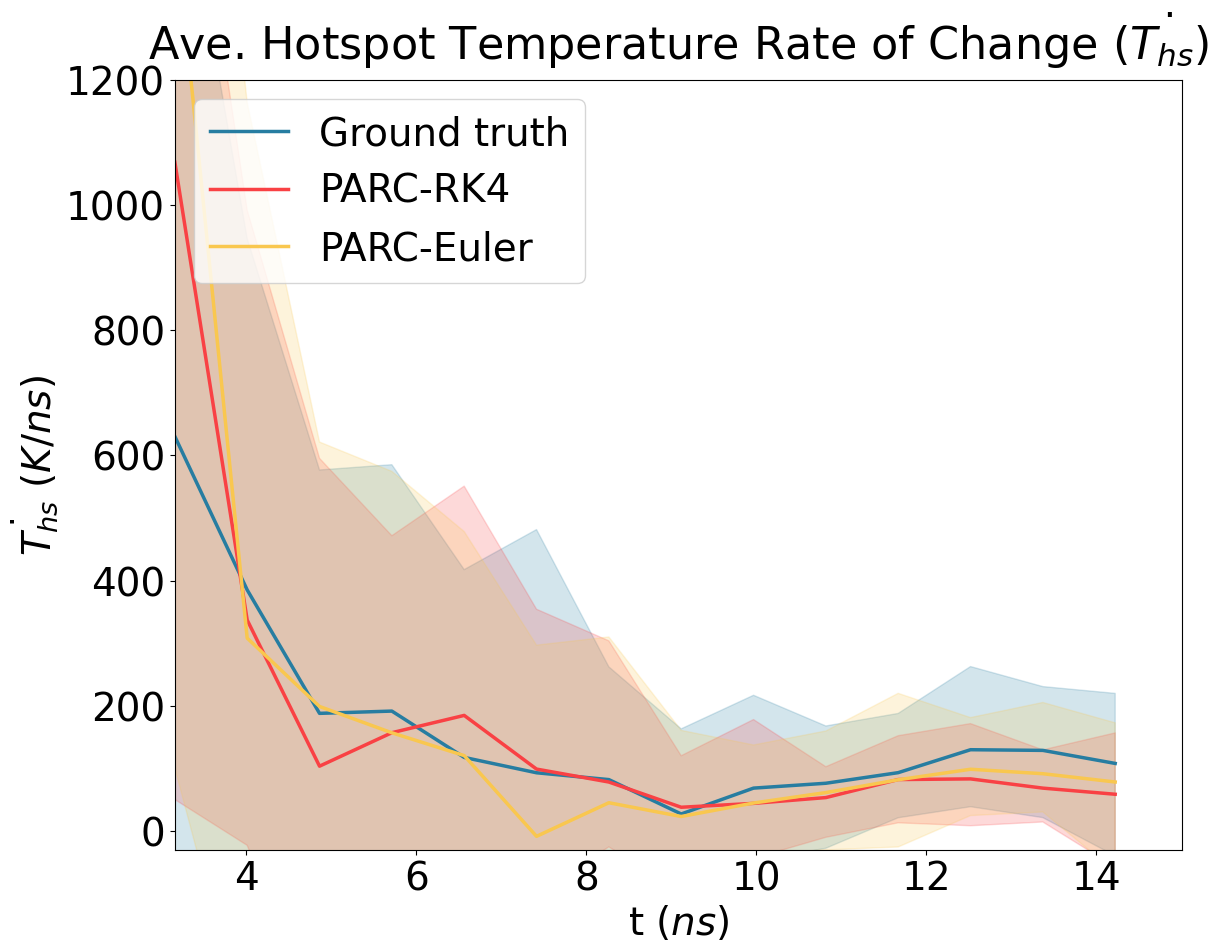

In [155]:
plot_sensitivity(y_true=gt_rate_hs_temp, y_pred_rk=parc_rate_hs_temp_rk, y_pred_euler = parc_rate_hs_temp_euler, metric='rate_hs_temp',ts=15)

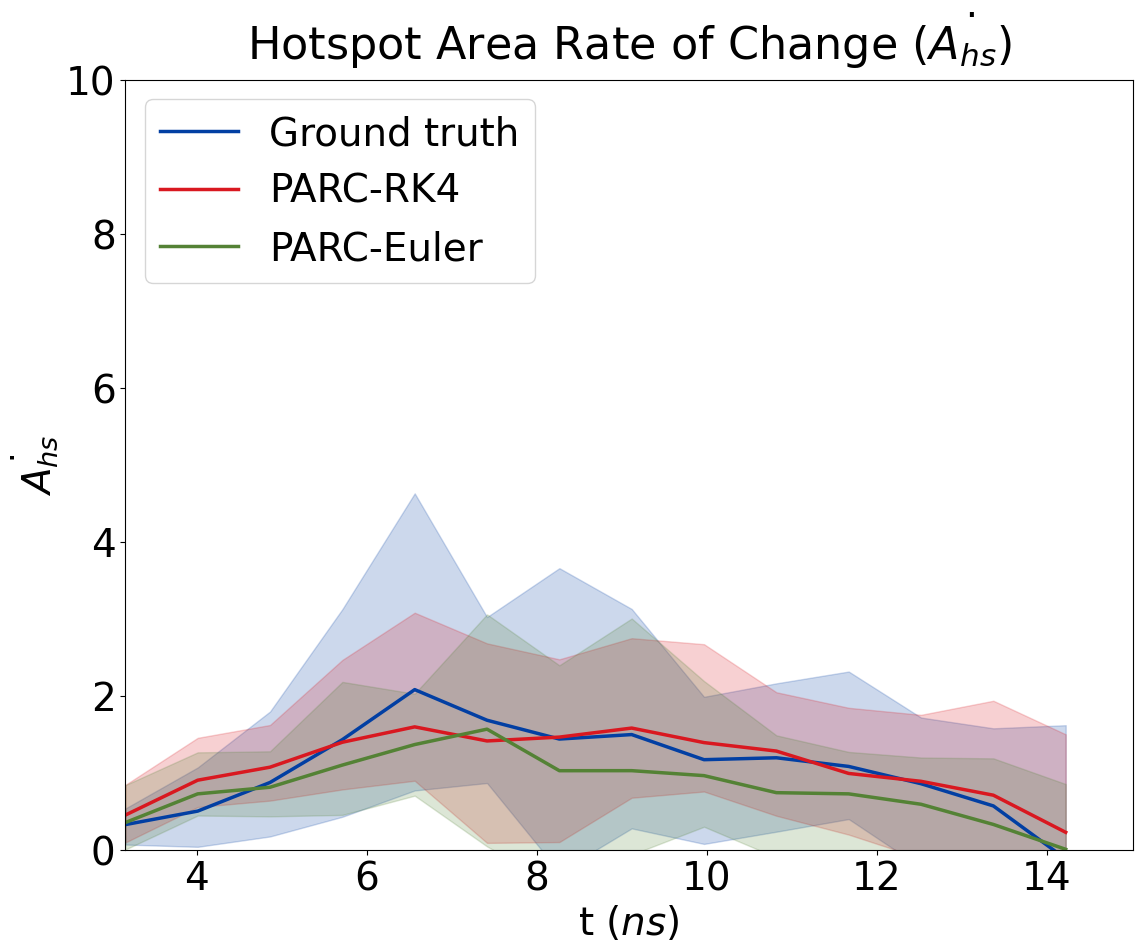

In [135]:
plot_sensitivity(y_true=gt_rate_hs_area, y_pred_rk=parc_rate_hs_area_rk, y_pred_euler = parc_rate_hs_area_euler, metric='rate_hs_area',ts=15)

## Physics-informed loss

In [ ]:
# define the high-order finite difference kernels
lapl_op = [[[[    0,   0, -1/12,   0,     0],
             [    0,   0,   4/3,   0,     0],
             [-1/12, 4/3,    -5, 4/3, -1/12],
             [    0,   0,   4/3,   0,     0],
             [    0,   0, -1/12,   0,     0]]]]

partial_y = [[[[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [1/12, -8/12, 0, 8/12, -1/12],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]]]

partial_x = [[[[0, 0, 1/12, 0, 0],
               [0, 0, -8/12, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 8/12, 0, 0],
               [0, 0, -1/12, 0, 0]]]]

In [ ]:
class loss_generator(nn.Module):
    ''' Loss generator for physics loss '''

    def __init__(self, dt = (2.0/100), dx = (6/128)):
        ''' Construct the derivatives, X = Width, Y = Height '''
       
        super(loss_generator, self).__init__()

        # spatial derivative operator
        self.laplace = Conv2dDerivative(
            DerFilter = lapl_op,
            resol = (dx**2),
            kernel_size = 5,
            name = 'laplace_operator').cuda()

        self.dx = Conv2dDerivative(
            DerFilter = partial_x,
            resol = (dx*1),
            kernel_size = 5,
            name = 'dx_operator').cuda()

        self.dy = Conv2dDerivative(
            DerFilter = partial_y,
            resol = (dx*1),
            kernel_size = 5,
            name = 'dy_operator').cuda()

        # temporal derivative operator
        self.dt = Conv1dDerivative(
            DerFilter = [[[-1, 0, 1]]],
            resol = (dt*2),
            kernel_size = 3,
            name = 'partial_t').cuda()

    def get_phy_Loss(self, output):

        # spatial derivatives
        laplace_u = self.laplace(output[1:-1, 0:1, :, :])  # [t,c,h,w]
        laplace_v = self.laplace(output[1:-1, 1:2, :, :])

        u_x = self.dx(output[1:-1, 0:1, :, :])
        u_y = self.dy(output[1:-1, 0:1, :, :])
        v_x = self.dx(output[1:-1, 1:2, :, :])
        v_y = self.dy(output[1:-1, 1:2, :, :])

        # temporal derivative - u
        u = output[:, 0:1, 2:-2, 2:-2]
        lent = u.shape[0]
        lenx = u.shape[3]
        leny = u.shape[2]
        u_conv1d = u.permute(2, 3, 1, 0)  # [height(Y), width(X), c, step]
        u_conv1d = u_conv1d.reshape(lenx*leny,1,lent)
        u_t = self.dt(u_conv1d)  # lent-2 due to no-padding
        u_t = u_t.reshape(leny, lenx, 1, lent-2)
        u_t = u_t.permute(3, 2, 0, 1)  # [step-2, c, height(Y), width(X)]

        # temporal derivative - v
        v = output[:, 1:2, 2:-2, 2:-2]
        v_conv1d = v.permute(2, 3, 1, 0)  # [height(Y), width(X), c, step]
        v_conv1d = v_conv1d.reshape(lenx*leny,1,lent)
        v_t = self.dt(v_conv1d)  # lent-2 due to no-padding
        v_t = v_t.reshape(leny, lenx, 1, lent-2)
        v_t = v_t.permute(3, 2, 0, 1)  # [step-2, c, height(Y), width(X)]

        u = output[1:-1, 0:1, 2:-2, 2:-2]  # [t, c, height(Y), width(X)]
        v = output[1:-1, 1:2, 2:-2, 2:-2]  # [t, c, height(Y), width(X)]

        assert laplace_u.shape == u_t.shape
        assert u_t.shape == v_t.shape
        assert laplace_u.shape == u.shape
        assert laplace_v.shape == v.shape

        R = 10000.0

        # 2D burgers eqn
        f_u = u_t + u * u_x + v * u_y - (1/R) * laplace_u
        f_v = v_t + u * v_x + v * v_y - (1/R) * laplace_v

        return f_u, f_v
    